In [1]:
# This script introduces QAT (Quantization Aware Training)

In [2]:
# 引用外部软件包
import torch # pytorch包
import torchvision # torchvision是pytorch官方提供的工具，包含很多常用数据集的封装等
import torchvision.transforms as transforms
import torch.nn as nn # nn 和下面的F均包含了主要的神经网络模块，包括卷积层、全连接层、池化层等等
import torch.nn.functional as F
import torch.optim as optim # 优化器

data_dir = "./data" # directory to download the dataset
epochs = 5 # number of epochs to train the model

In [3]:
# 确保device为gpu，否则会花费过长时间。
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [4]:
# Load training and test data from the CIFAR10 dataset.
# torchvision是pytorch官方集成的工具库，包括学界常用的数据集和数据预处理方式。
transform = transforms.Compose(
    [transforms.ToTensor(), # 将数据归一化，并转换成tensor的形式
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # 预处理数据的方式，normalize是将图像进行规则化。

trainset = torchvision.datasets.CIFAR10(root= data_dir+"/train", train=True,
                                        download=True, transform=transform) #定义了训练集，path是训练数据所在地址。
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2) #定义数据迭代器，batchsize为一次迭代训练，送进去图像的数量（可以尝试调整，看看会发生什么）。shuffle表示要不要打乱训练图像的排序。

testset = torchvision.datasets.CIFAR10(root=data_dir+"/test", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:21<00:00, 8110237.85it/s] 


Extracting /home/tsinghuaee51/cifar10\cifar-10-python.tar.gz to /home/tsinghuaee51/cifar10
Files already downloaded and verified


In [5]:
# Define a simple CNN that classifies CIFAR images.
# The network provided is similar to LeNet-5, and it has the following architecture:

# **Layer** |     **Type**    | **Input Shape** | **Output Shape** | **Activation**
#   conv1   |  Convolutional  |     3x32x32     |     6x28x28      |      ReLU 
#   pool1   |     Max pool    |     6x28x28     |     6x14x14      |      None                
#   conv2   |  Convolutional  |     6x14x14     |     16x10x10     |      ReLU                
#   pool2   |     Max pool    |     16x10x10    |     16x5x5       |      None                
#   fc1     | Fully-connected |       400       |       120        |      ReLU                
#   fc2     | Fully-connected |       120       |       84         |      ReLU                
#   fc3     | Fully-connected |       84        |       10         |      None                

# None of the layers in the network have a bias associated with them.
# This makes them easier to quantize.
# Towards the end of this assignment, we will add biases to the final layer and quantize it as well.

In [6]:
# 重新定义conv函数与fc函数
import math
def TorchRound():
    """
    Apply STE to clamp function.
    """
    class identity_quant(torch.autograd.Function):
        @staticmethod
        def forward(ctx, input):
            out = torch.round(input)
            return out

        @staticmethod
        def backward(ctx, grad_output):
            return grad_output

    return identity_quant().apply

def quant_max(tensor):
    """
    Returns the max value for symmetric quantization.
    """
    return torch.abs(tensor.detach()).max() + 1e-8

class quant_weight(nn.Module):
    """
    Quantization function for quantize weight with maximum.
    """

    def __init__(self, k_bits=8):
        super(quant_weight, self).__init__()
        self.k_bits = k_bits
        self.qmax = 2. ** (k_bits -1) - 1.
        self.round = TorchRound()

    def forward(self, input):
        max_val = quant_max(input)
        weight = input * self.qmax / max_val
        q_weight = self.round(weight)
        q_weight = q_weight * max_val / self.qmax
        return q_weight

class QuantConv2d(nn.Module):
    """
    A convolution layer with quantized weight.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                    padding=0, dilation=1, groups=1, bias=False, k_bits=8): # 默认使用bias=False的情况
        super(QuantConv2d, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(out_channels,in_channels,kernel_size,kernel_size))
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.in_channels = in_channels
        self.kernel_size = (kernel_size, kernel_size)
        self.bias_flag = bias
        if self.bias_flag:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
            nn.init.constant_(self.bias)
        else:
            self.register_parameter('bias', None)
        self.k_bits = k_bits
        self.quant_weight = quant_weight(k_bits = k_bits)
        self.output = None
        nn.init.kaiming_normal_(self.weight) # 初始化参数
        

    def forward(self, input, order=None):
        return F.conv2d(input, self.quant_weight(self.weight), self.bias, self.stride, self.padding, self.dilation, self.groups)

class QuantFC(nn.Module):
    """
    A Fully Connected layer with quantized weight.
    """

    def __init__(self, in_features, out_features, bias=False, k_bits=8): # 默认使用bias=False的情况
        super(QuantFC, self).__init__()
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias_flag = bias
        if self.bias_flag:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.k_bits = k_bits
        self.quant_weight = quant_weight(k_bits = k_bits)
        nn.init.kaiming_normal_(self.weight) # 初始化参数


    def forward(self, input, order=None):
        return F.linear(input, self.quant_weight(self.weight), self.bias)

In [7]:
class quant_act(nn.Module):
    """
    Quantization function for quantize activation with parameterized max scale.
    """
    def __init__(self, k_bits=8, decay=0.5):
        super(quant_act, self).__init__()
        self.k_bits = k_bits
        self.qmax = 2. ** (self.k_bits -1) -1.
        self.round = TorchRound()
        self.decay = decay
        self.alpha = nn.Parameter(torch.Tensor(10))
        self.register_buffer('max_val', torch.ones(1))

    def _ema(self, x):
        act = x.reshape(x.shape[0], -1)
        # print(act.shape)
        max_val = torch.mean(torch.max(act, dim=1)[0])

        self.max_val = (1.0-self.decay) * max_val + self.decay * self.max_val

    def forward(self, x):
            
        
        act = x
        self._ema(x)
        self.alpha.data = self.max_val.unsqueeze(0)
        act = torch.max(torch.min(x, self.alpha), -self.alpha)
        
        act = act * self.qmax / self.alpha
        q_act = self.round(act)
        q_act = q_act * self.alpha / self.qmax
    
        return q_act

In [8]:
# 网络定义，conv2d是卷积层，linear是全连接层。forward下定义了计算图，显示送进来的图像（x）会怎么处理。
class Net(nn.Module):
    #网络结构:2层卷积层、1层最大值池化层、3层全连接层，留意这些参数的内涵
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = QuantConv2d(3, 6, 5, bias=False, k_bits=8) # Weight for 8bit
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = QuantConv2d(6, 16, 5, bias=False, k_bits=8)
        self.fc1 = QuantFC(16 * 5 * 5, 120, bias=False, k_bits=8)
        self.fc2 = QuantFC(120, 84, bias=False, k_bits=8)
        self.fc3 = QuantFC(84, 10, bias=False, k_bits=8)

        self.quant_act1 = quant_act(k_bits=8) # activation for 8 bit
        self.quant_act2 = quant_act(k_bits=8)
        self.quant_act3 = quant_act(k_bits=8)
        self.quant_act4 = quant_act(k_bits=8)
        # self.quant_act5 = quant_act(k_bits=8)
    #定义前向传播,将tensor数据送入网络之后的计算图
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.quant_act1(x)

        x = self.pool(F.relu(self.conv2(x)))
        x = self.quant_act2(x)

        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.quant_act3(x)

        x = F.relu(self.fc2(x))
        x = self.quant_act4(x)

        x = self.fc3(x)
        # x = self.quant_act5(x)
        return x

net = Net().to(device)
# 到这里，我们定义好了网络和数据集的使用方式

In [9]:
from torch.utils.data import DataLoader
#将训练集的dataloader送入网络进行训练,每次读取batchsize数量的数据
def train(model: nn.Module, dataloader: DataLoader):
    criterion = nn.CrossEntropyLoss() # loss function（交叉熵损失函数）
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #optimizer，使用SGD优化器训练，第一个参数表示model的所有参数都会参与训练，学习率为0.001，动量为0.9

    for epoch in range(epochs):  # loop over the dataset multiple times.
        running_loss = 0.0 
        for i, data in enumerate(dataloader, 0): # dataloader是数据迭代器，从这里每次读出batchsize数量的数据。
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs) # 将数据送进网络，得到结果
            loss = criterion(outputs, labels) # 计算结果和标签的交叉熵损失函数
            loss.backward() # 基于上述损失函数求解梯度
            optimizer.step() # 更新参数

            # print statistics
            running_loss += loss.item() # 将loss的值取出来，记录其变化
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad(): # 测试时不用求解梯度，因此可以设置不计算梯度的模式
        for data in dataloader:
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images) # get 1 batch worth of image predictions (i.e. 4 predictions of 10 each)
            other, predicted = torch.max(outputs.data, 1) # other == values, predicted == indicies
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += images.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

In [10]:
train(net, trainloader) # 进行训练，将网络定义和数据迭代器传给train函数。

[1,  2000] loss: 1.892
[1,  4000] loss: 1.713
[1,  6000] loss: 1.605
[1,  8000] loss: 1.556
[1, 10000] loss: 1.525
[1, 12000] loss: 1.480
[2,  2000] loss: 1.436
[2,  4000] loss: 1.406
[2,  6000] loss: 1.423
[2,  8000] loss: 1.394
[2, 10000] loss: 1.372
[2, 12000] loss: 1.370
[3,  2000] loss: 1.293
[3,  4000] loss: 1.301
[3,  6000] loss: 1.322
[3,  8000] loss: 1.323
[3, 10000] loss: 1.297
[3, 12000] loss: 1.269
[4,  2000] loss: 1.221
[4,  4000] loss: 1.215
[4,  6000] loss: 1.231
[4,  8000] loss: 1.227
[4, 10000] loss: 1.253
[4, 12000] loss: 1.239
[5,  2000] loss: 1.157
[5,  4000] loss: 1.166
[5,  6000] loss: 1.196
[5,  8000] loss: 1.190
[5, 10000] loss: 1.191
[5, 12000] loss: 1.179
Finished Training


In [11]:
# Now that the CNN has been trained, let's test it on our test dataset.
score = test(net, testloader)
print('Accuracy of the network on the test images: {}%'.format(score))

Accuracy of the network on the test images: 56.83%


In [12]:
# Define a convenience function which we use to copy CNN's.
from copy import deepcopy

def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv2d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [13]:
# Visualize Weights

conv1: the range is [-1.08005, 0.96903]
conv1: the 3-sigma range is [-1.08005, 0.96903]


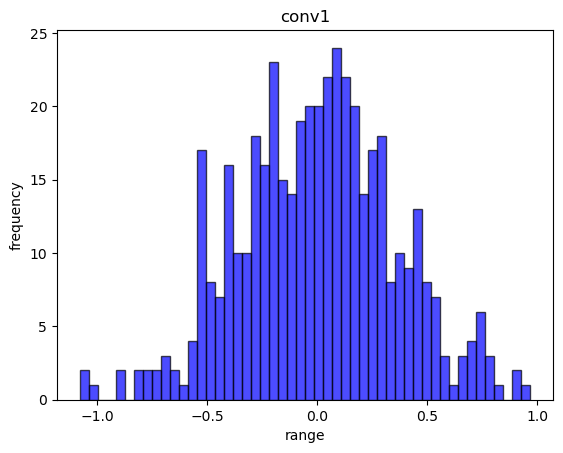

conv2: the range is [-0.66882, 0.79763]
conv2: the 3-sigma range is [-0.66882, 0.66882]


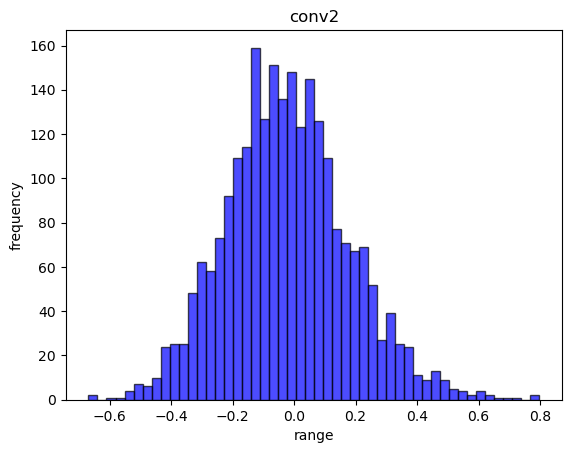

fc1: the range is [-0.50037, 0.66469]
fc1: the 3-sigma range is [-0.28616, 0.28616]


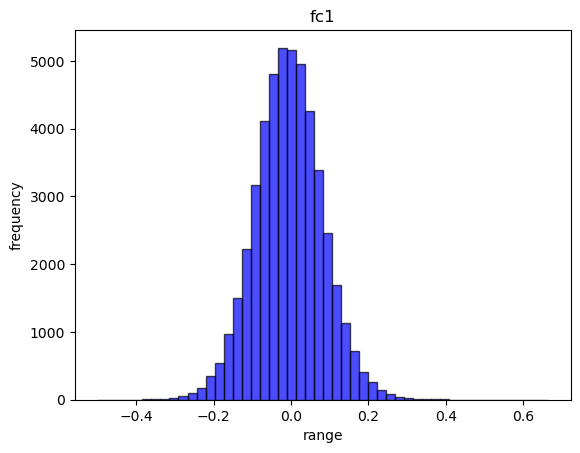

fc2: the range is [-0.50997, 0.50413]
fc2: the 3-sigma range is [-0.42109, 0.42109]


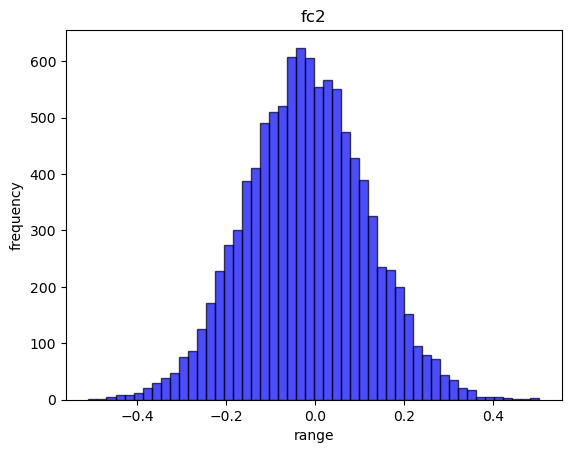

fc3: the range is [-0.41264, 0.43350]
fc3: the 3-sigma range is [-0.41264, 0.41264]


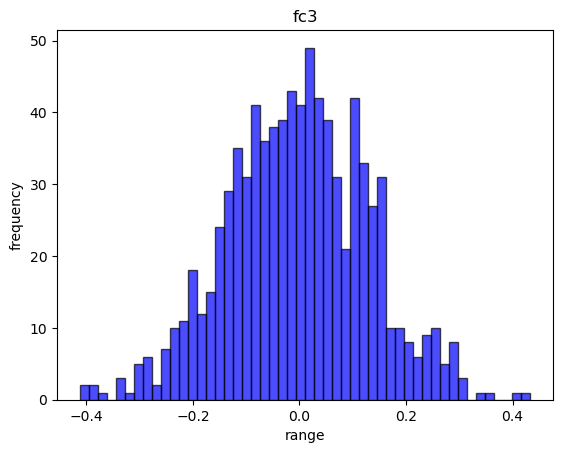

In [14]:
import matplotlib.pyplot as plt
import numpy as np

name = ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']
n = 0

for layer in net.children(): # 遍历类的成员
    if isinstance(layer, QuantConv2d) or isinstance(layer, QuantFC):
        weight = layer.weight.data.cpu().view(-1).numpy()
        print(name[n] + ": the range is [{:.5f}, {:.5f}]".format(weight.min(), weight.max()))

        # find 3-sigma range (u-3s, u+3s), 该范围能囊括99.73%参数
        sigma3 = int(np.size(weight)*0.0027) 
        sigma3_value = np.abs(weight)[np.argpartition(np.abs(weight), -sigma3)[-sigma3]]
        print(name[n] + ": the 3-sigma range is [{:.5f}, {:.5f}]".format(max(-sigma3_value, weight.min()), min(sigma3_value,weight.max())))

        plt.hist(weight, bins=50, facecolor="blue", edgecolor="black", alpha=0.7) # 画直方图
        plt.xlabel("range")
        plt.ylabel("frequency")
        plt.title(name[n])
        plt.show()
        n += 1
        
# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)